In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from pylab import rcParams
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [248]:
rcParams['figure.figsize'] = (10,5)
rcParams['figure.dpi'] = (150)

In [249]:
confirmed = pd.read_csv('/content/drive/My Drive/time_series_covid19_confirmed_US.csv')
confirmed.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,765,773,810,823,838,845,863,877,891,900,909,932,941,949,963,972,988,1010,1024,1030,1030,1050,1065,1086,1169,1174,1162,1188,1196,1196,1206,1218,1219,1235,1241,1240,1255,1264,1266,1286
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1579,1669,1796,1914,1990,2077,2164,2423,2473,2620,2665,2727,2793,2865,2984,3056,3095,3175,3210,3263,3322,3380,3443,3502,3544,3651,3670,3710,3744,3791,3839,3877,3888,3906,3931,3957,3997,4037,4069,4083
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,444,448,465,472,479,484,487,501,507,516,523,529,535,538,539,550,554,562,563,563,564,565,569,573,575,576,579,581,586,590,598,604,605,606,613,619,622,626,629,633
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,243,251,260,265,274,278,282,284,297,312,317,327,330,336,344,355,360,364,374,381,384,413,416,426,438,442,444,453,457,465,469,469,474,476,490,494,501,503,510,510
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,395,406,421,441,465,479,498,528,552,569,578,601,607,623,658,685,704,722,736,741,745,759,774,788,800,812,816,825,835,848,854,860,863,887,901,912,930,931,934,946


In [250]:
confirmed.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'], axis=1, inplace=True)
confirmed.reset_index(drop=True)
confirmed.head()

,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,765,773,810,823,838,845,863,877,891,900,909,932,941,949,963,972,988,1010,1024,1030,1030,1050,1065,1086,1169,1174,1162,1188,1196,1196,1206,1218,1219,1235,1241,1240,1255,1264,1266,1286
1,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1579,1669,1796,1914,1990,2077,2164,2423,2473,2620,2665,2727,2793,2865,2984,3056,3095,3175,3210,3263,3322,3380,3443,3502,3544,3651,3670,3710,3744,3791,3839,3877,3888,3906,3931,3957,3997,4037,4069,4083
2,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,444,448,465,472,479,484,487,501,507,516,523,529,535,538,539,550,554,562,563,563,564,565,569,573,575,576,579,581,586,590,598,604,605,606,613,619,622,626,629,633
3,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,243,251,260,265,274,278,282,284,297,312,317,327,330,336,344,355,360,364,374,381,384,413,416,426,438,442,444,453,457,465,469,469,474,476,490,494,501,503,510,510
4,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,395,406,421,441,465,479,498,528,552,569,578,601,607,623,658,685,704,722,736,741,745,759,774,788,800,812,816,825,835,848,854,860,863,887,901,912,930,931,934,946


In [251]:
confirmed_NY = confirmed[confirmed['Province_State']=='New York']
confirmed_NY.drop(['Province_State'], axis=1, inplace=True)
confirmed_NY = confirmed_NY.sum(axis=0)
confirmed_NY.tail()

8/20/20    427803
8/21/20    428512
8/22/20    429165
8/23/20    429737
8/24/20    430145
dtype: int64

In [252]:
confirmed_NJ = confirmed[confirmed['Province_State']=='New Jersey']
confirmed_NJ.drop(['Province_State'], axis=1, inplace=True)
confirmed_NJ = confirmed_NJ.sum(axis=0)
confirmed_NJ.tail()

8/20/20    188527
8/21/20    188817
8/22/20    189346
8/23/20    189494
8/24/20    189719
dtype: int64

In [253]:
def reverse_cumsum(array):
  l = []
  l.append(array[0])
  for i in range(len(array)-1):
    l.append(array[i+1] - array[i])
  return np.array(l)

In [254]:
confirmed_NJ = confirmed_NJ.to_numpy()
NJ = reverse_cumsum(confirmed_NJ)
NJ[-5:]

array([100, 290, 529, 148, 225])

In [255]:
confirmed_NY = confirmed_NY.to_numpy()
NY = reverse_cumsum(confirmed_NY)
NY[-5:]

array([601, 709, 653, 572, 408])

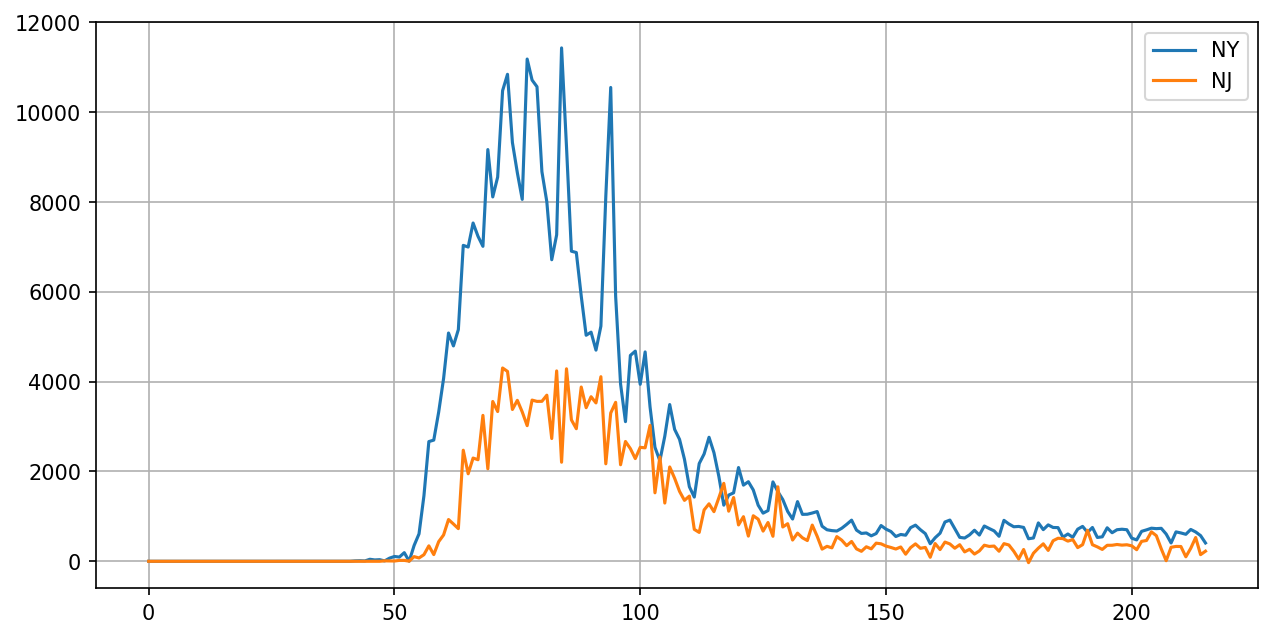

In [256]:
plt.plot(NY, label='NY')
plt.plot(NJ, label='NJ')
plt.legend()
plt.grid()
plt.show()

In [257]:
NJ.shape, NY.shape

((216,), (216,))

In [258]:
NJ, NY = NJ.reshape(-1,1), NY.reshape(-1,1)
NJ.shape, NY.shape

((216, 1), (216, 1))

In [259]:
train_size = int(len(NJ)*0.80)
NJ_train, NJ_test = NJ[0:train_size], NJ[train_size:]
NY_train, NY_test = NY[0:train_size], NY[train_size:]

NJ_train.shape, NY_test.shape

((172, 1), (44, 1))

In [260]:
NY_scaler = StandardScaler()
NY_train = NY_scaler.fit_transform(NY_train)
NY_test = NY_scaler.transform(NY_test)

In [261]:
NJ_scaler = StandardScaler()
NJ_train = NJ_scaler.fit_transform(NJ_train)
NJ_test = NJ_scaler.transform(NJ_test)

In [262]:
def create_dataset(dataset, timesteps=1):
  X, y = [], []
  for i in range(len(dataset) - timesteps):
    X.append(dataset[i:(i + timesteps)])
    y.append(dataset[i + timesteps])
  return np.array(X), np.array(y)

In [263]:
TIME_STEPS = 1
n_features = 1
BATCH_SIZE = 1
n_epochs = 200

In [264]:
NY_train_X, NY_train_y = create_dataset(dataset=NY_train, timesteps=TIME_STEPS)
NY_test_X, NY_test_y = create_dataset(dataset=NY_test, timesteps=TIME_STEPS)

NJ_train_X, NJ_train_y = create_dataset(dataset=NY_train, timesteps=TIME_STEPS)
NJ_test_X, NJ_test_y = create_dataset(dataset=NY_test, timesteps=TIME_STEPS)

In [265]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

In [266]:
NY_model = Sequential()

NY_model.add(LSTM(units=32, activation=sigmoid, return_sequences=True, input_shape=[TIME_STEPS, n_features]))
NY_model.add(Dropout(rate=0.3))
NY_model.add(LSTM(units=32, activation=sigmoid, return_sequences=True))
NY_model.add(Dropout(rate=0.3))
NY_model.add(LSTM(units=32, activation=sigmoid))
NY_model.add(Dropout(rate=0.3))
NY_model.add(Dense(units=1))

NY_model.compile(optimizer=Adam(learning_rate=0.0001), loss=MSE)

In [267]:
NY_history = NY_model.fit(NY_train_X, NY_train_y, 
                          epochs=n_epochs, shuffle=False, 
                          verbose=1, batch_size=BATCH_SIZE, 
                          validation_data=(NY_test_X, NY_test_y))


Epoch 1/200
171/171 [==============================] - 1s 5ms/step - loss: 1.4316 - val_loss: 0.0032
Epoch 2/200
171/171 [==============================] - 0s 2ms/step - loss: 1.3486 - val_loss: 0.0222
Epoch 3/200
171/171 [==============================] - 0s 3ms/step - loss: 1.2275 - val_loss: 0.0526
Epoch 4/200
171/171 [==============================] - 0s 2ms/step - loss: 1.2021 - val_loss: 0.0857
Epoch 5/200
171/171 [==============================] - 0s 2ms/step - loss: 1.0687 - val_loss: 0.1169
Epoch 6/200
171/171 [==============================] - 0s 2ms/step - loss: 1.0738 - val_loss: 0.1512
Epoch 7/200
171/171 [==============================] - 0s 2ms/step - loss: 1.0699 - val_loss: 0.1782
Epoch 8/200
171/171 [==============================] - 0s 3ms/step - loss: 1.0251 - val_loss: 0.2023
Epoch 9/200
171/171 [==============================] - 0s 3ms/step - loss: 1.1042 - val_loss: 0.2205
Epoch 10/200
171/171 [==============================] - 0s 3ms/step - loss: 1.0895 - val_lo

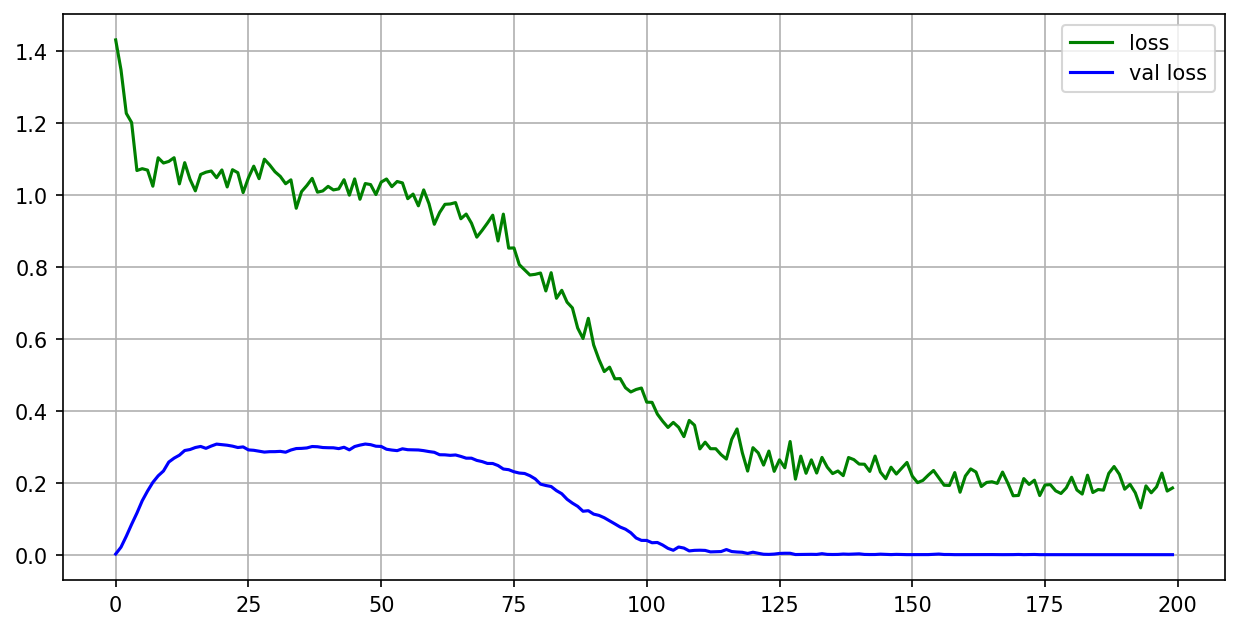

In [268]:
plt.plot(NY_history.history['loss'], 'g-', label='loss')
plt.plot(NY_history.history['val_loss'], 'b-', label='val loss')
plt.legend()
plt.grid()
plt.show()

In [269]:
NY_train_pred = NY_model.predict(NY_train_X)

In [270]:
print('Root Mean Squared Error: ')
np.sqrt(mean_squared_error(y_true=NY_train_y, y_pred=NY_train_pred))

Root Mean Squared Error: 


0.28478038070007583

In [271]:
NY_test_pred = NY_model.predict(NY_test_X)

In [272]:
print('Root Mean Squared Error: ')
np.sqrt(mean_squared_error(y_true=NY_test_y, y_pred=NY_test_pred))

Root Mean Squared Error: 


0.0373297378227602

In [273]:
NY_train_true = NY_scaler.inverse_transform(NY_train_y)
NY_train_pred = NY_scaler.inverse_transform(NY_train_pred)

In [274]:
print('Root Mean Squared Error: ')
np.sqrt(mean_squared_error(y_true=NY_train_true, y_pred=NY_train_pred))

Root Mean Squared Error: 


875.4404465082903

In [275]:
NY_test_true = NY_scaler.inverse_transform(NY_test_y)
NY_test_pred = NY_scaler.inverse_transform(NY_test_pred)

In [276]:
print('Root Mean Squared Error: ')
np.sqrt(mean_squared_error(y_true=NY_test_true, y_pred=NY_test_pred))

Root Mean Squared Error: 


114.75496108486917

In [277]:
NY_model.save_weights('/content/drive/My Drive/NY_model.h5')

In [278]:
NJ_model = Sequential()

NJ_model.add(LSTM(units=32, activation=sigmoid, return_sequences=True, input_shape=[TIME_STEPS, n_features]))
NJ_model.add(Dropout(rate=0.3))
NJ_model.add(LSTM(units=32, activation=sigmoid, return_sequences=True))
NJ_model.add(Dropout(rate=0.3))
NJ_model.add(LSTM(units=32, activation=sigmoid))
NJ_model.add(Dropout(rate=0.3))
NJ_model.add(Dense(units=1))

NJ_model.compile(optimizer=Adam(learning_rate=0.00001), loss=MSE)

NJ_model.load_weights('/content/drive/My Drive/NY_model.h5')

NJ_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 1, 32)             4352      
_________________________________________________________________
dropout_33 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dropout_34 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

In [279]:
NJ_history = NJ_model.fit(NJ_train_X, NJ_train_y, 
                          epochs=n_epochs, shuffle=False, 
                          verbose=1, batch_size=BATCH_SIZE, 
                          validation_data=(NJ_test_X, NJ_test_y))

Epoch 1/200
171/171 [==============================] - 1s 5ms/step - loss: 0.1764 - val_loss: 0.0014
Epoch 2/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1786 - val_loss: 0.0014
Epoch 3/200
171/171 [==============================] - 0s 2ms/step - loss: 0.2060 - val_loss: 0.0014
Epoch 4/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1992 - val_loss: 0.0014
Epoch 5/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1827 - val_loss: 0.0014
Epoch 6/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1729 - val_loss: 0.0014
Epoch 7/200
171/171 [==============================] - 0s 2ms/step - loss: 0.2221 - val_loss: 0.0014
Epoch 8/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1715 - val_loss: 0.0014
Epoch 9/200
171/171 [==============================] - 0s 2ms/step - loss: 0.2184 - val_loss: 0.0014
Epoch 10/200
171/171 [==============================] - 0s 2ms/step - loss: 0.2097 - val_lo

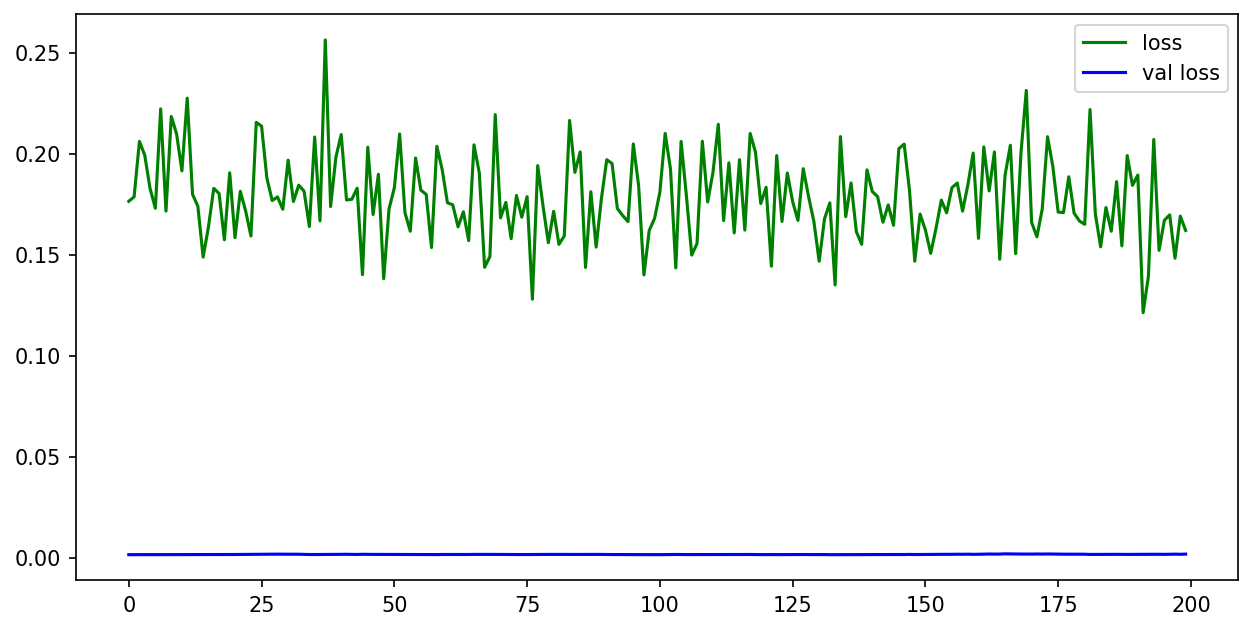

In [280]:
plt.plot(NJ_history.history['loss'], 'g-', label='loss')
plt.plot(NJ_history.history['val_loss'], 'b-', label='val loss')
plt.legend()
plt.show()

In [281]:
NJ_train_pred = NJ_model.predict(x=NJ_train_X)

In [282]:
print('Root Mean Squared Error: ')
np.sqrt(mean_squared_error(y_true=NJ_train_y, y_pred=NJ_train_pred))

Root Mean Squared Error: 


0.28616450698259627

In [283]:
NJ_test_pred = NJ_model.predict(x=NJ_test_X)

In [284]:
print('Root Mean Squared Error: ')
np.sqrt(mean_squared_error(y_true=NJ_test_y, y_pred=NJ_test_pred))

Root Mean Squared Error: 


0.04102914761089142

In [285]:
NJ_train_true = NJ_scaler.inverse_transform(NJ_train_y)
NJ_train_pred = NJ_scaler.inverse_transform(NJ_train_pred)

In [286]:
print('Root Mean Squared Error: ')
np.sqrt(mean_squared_error(y_true=NJ_train_true, y_pred=NJ_train_pred))

Root Mean Squared Error: 


364.5293993068899

In [287]:
NJ_test_true = NJ_scaler.inverse_transform(NJ_test_y)
NJ_test_pred = NJ_scaler.inverse_transform(NJ_test_pred)

In [288]:
print('Root Mean Squared Error: ')
np.sqrt(mean_squared_error(y_true=NJ_test_true, y_pred=NJ_test_pred))

Root Mean Squared Error: 


52.26479579185215

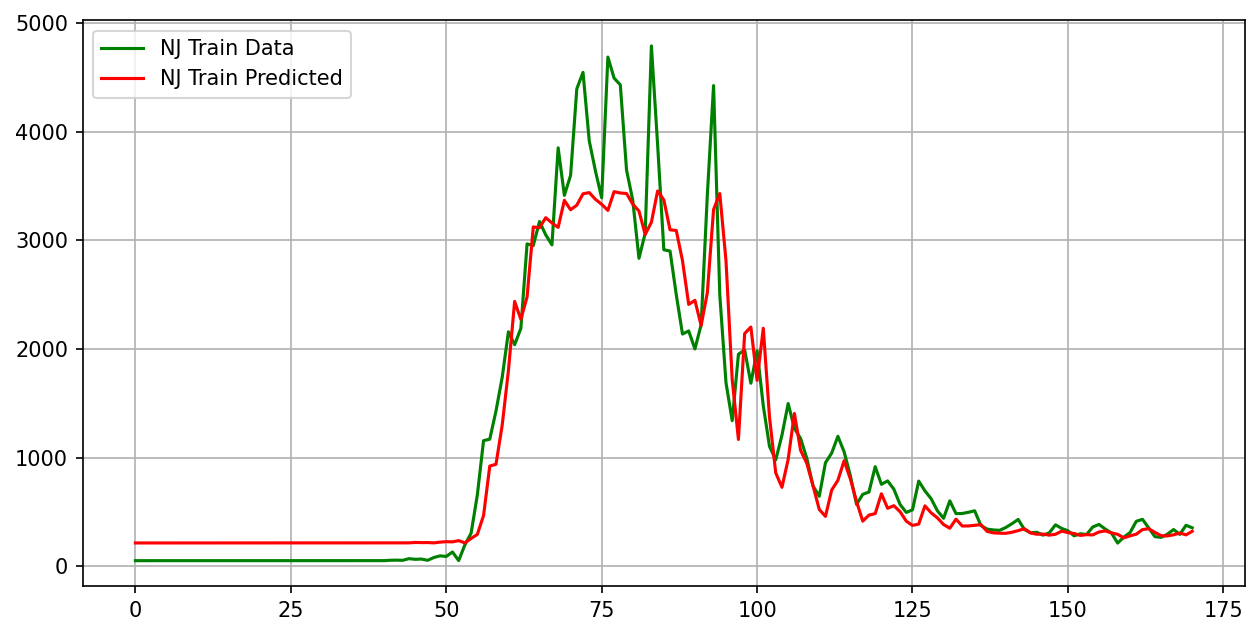

In [289]:
plt.plot(NJ_train_true, 'g-', label='NJ Train Data')
plt.plot(NJ_train_pred, 'r-', label='NJ Train Predicted')
plt.legend(loc=2)
plt.grid()
plt.show()

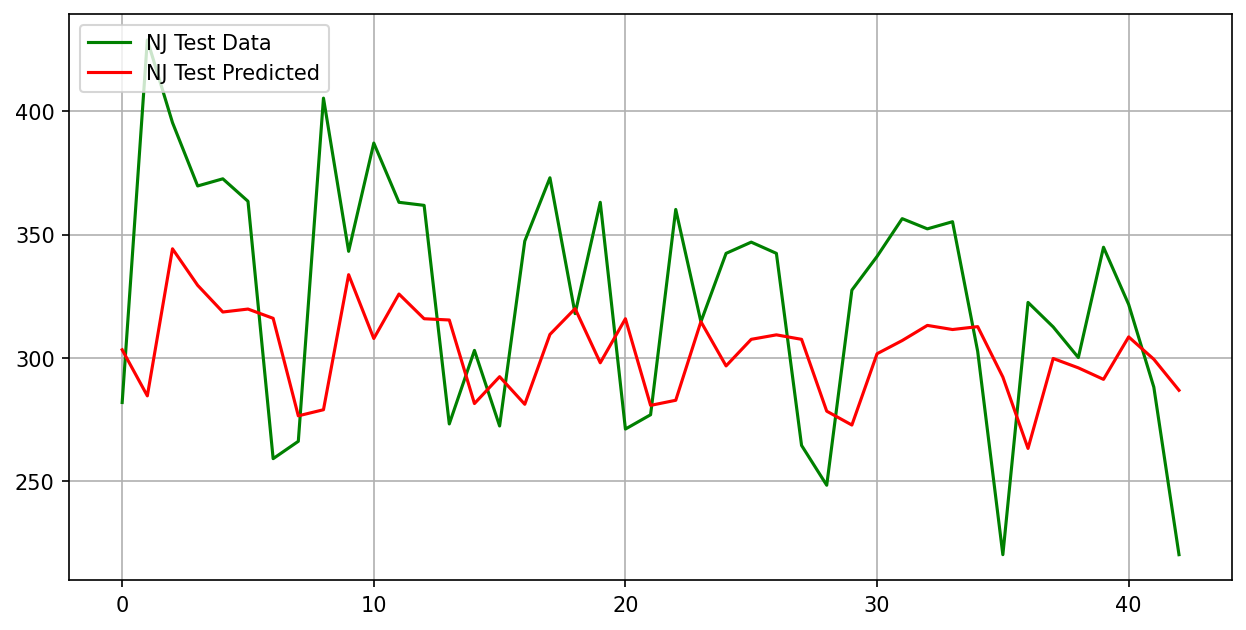

In [290]:
plt.plot(NJ_test_true, 'g-', label='NJ Test Data')
plt.plot(NJ_test_pred, 'r-', label='NJ Test Predicted')
plt.legend(loc=2)
plt.grid()
plt.show()

In [291]:
X_input = NJ_test_y[-TIME_STEPS:]
temp_input = X_input.tolist()

In [292]:
output_list = []
i = 0
FORECASTED_DAYS = 10
while(i<FORECASTED_DAYS):
  if(len(temp_input)>TIME_STEPS):
    X_input = np.array(temp_input[1:])
    X_input = X_input.reshape(1, TIME_STEPS, n_features)
    y_hat = NJ_model.predict(X_input)
    temp_input.extend(y_hat.tolist())
    temp_input = temp_input[1:]
    output_list.extend(y_hat.tolist())
    i+=1

  else:
    X_input = X_input.reshape(1, TIME_STEPS, n_features)
    y_hat = NJ_model.predict(X_input)
    temp_input.extend(y_hat.tolist())
    output_list.extend(y_hat.tolist())
    i+=1

In [293]:
y_forecast = NJ_scaler.inverse_transform(output_list)

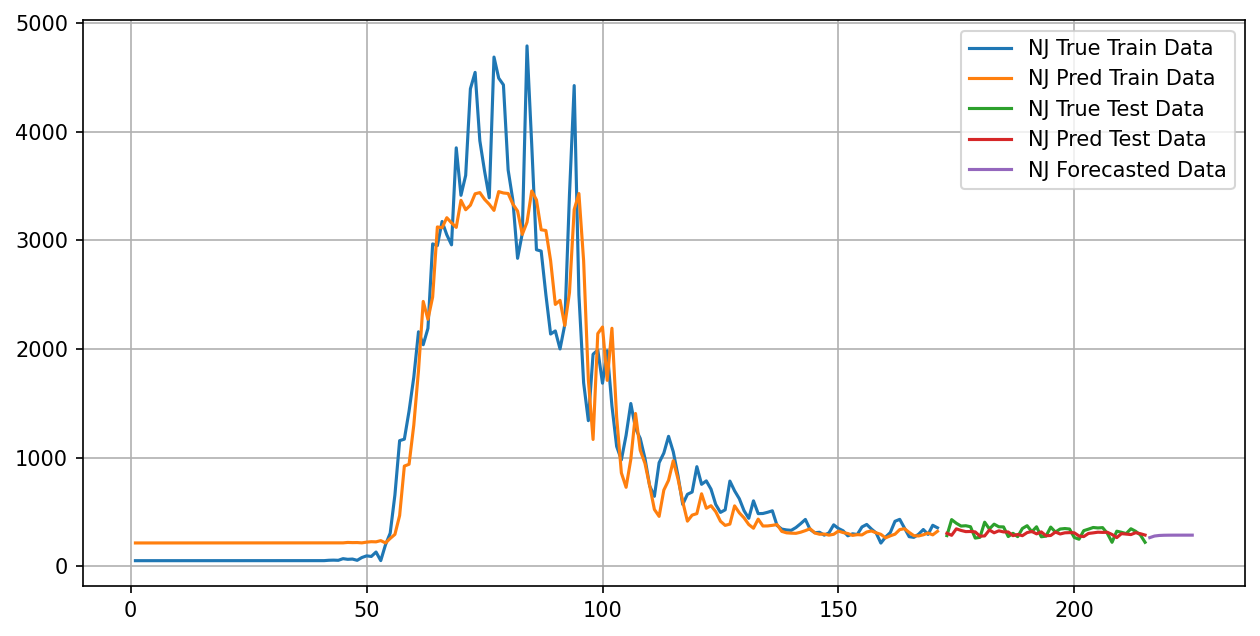

In [294]:
plt.plot(np.arange(TIME_STEPS, (len(NJ_train_true)+TIME_STEPS)), NJ_train_true, label='NJ True Train Data')
plt.plot(np.arange(TIME_STEPS, (len(NJ_train_true)+TIME_STEPS)), NJ_train_pred, label='NJ Pred Train Data')
plt.plot(np.arange(TIME_STEPS+len(NJ_train_true)+TIME_STEPS, len(NJ)), NJ_test_true, label='NJ True Test Data')
plt.plot(np.arange(TIME_STEPS+len(NJ_train_true)+TIME_STEPS, len(NJ)), NJ_test_pred, label='NJ Pred Test Data')
plt.plot(np.arange(len(NJ), len(NJ)+FORECASTED_DAYS), y_forecast, label='NJ Forecasted Data')
plt.legend()
plt.grid()
plt.show()

In [295]:
y_forecast

array([[263.22531411],
       [277.90445471],
       [283.12626597],
       [285.01206767],
       [285.69670245],
       [285.94597116],
       [286.03670406],
       [286.06965643],
       [286.08172884],
       [286.08613261]])